In [698]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import fftpack
import math
from collections import defaultdict
from heapq import heappush, heappop, heapify

In [699]:
# Some global functions

# split takes a matrix and separate it on pixel sections given the num size
def split(matrix, num):
    sections = []
    for i in range(0, matrix.shape[0], num):
        for j in range(0, matrix.shape[1], num):
            section = matrix[i:i+num, j:j+num]
            sections.append(section)

    return sections
        

## Inicialização
Vamos começar carregando a imagem que será utilizada no processo de compressão, além de definir váriaveis globais que serão utlizadas ao longo do notebook.

(667, 1000, 3)


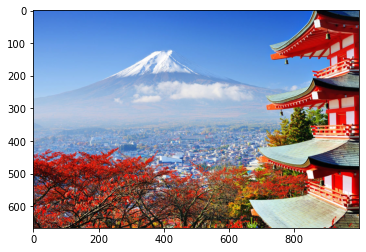

In [700]:
img = cv2.imread("japan.jpg")
img_width = img.shape[1]
img_height = img.shape[0]

print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) # OpenCV assume que estamos utilizando o espaço de cores BGR

## Compressor de Imagens
O método utilizado nesse trabalho seguirá as diretrizes do método JPEG para imagens cromáticas (com cores). Será um método com perdas. Esse método pode ser dividido em 5 etapas:
1. Conversão do espaço de cores
2. Downsampling da chrominance
3. Aplicação da DCT
4. Quantização
5. Codificação de Símbolos utilzando Huffman


### Conversão do Espaço de Cores
Cada pixel de uma imagem colorida é dividida em 3 valores: R(red), G(green), B(blue). No método JPEG, esses valores são convertidos para Y(Luminance) Cb(blue chrominance) Cr(red chrominance). Isso é feito pois o olho humano é capaz de detectar brilho e luminâcia melhor do que detectar cores. Ao separar as cores desse modo, podemos, no próximo passo (Chrominance Downsampling) descartar algumas informações de Cb e Cr, de forma a já diminuir o tamanho necessário para cada pixel enquanto mantemos Y(que se refere ao brilho) intacto. Nesse caso, exploramos a redundânica psicovisual ao remover informações que não são facilmente detectadas, e mantendo aquelas que conseguimos perceber melhor.

In [701]:
def convertRGBToYCbCr(imgInRGB):
    YCbCr_img = cv2.cvtColor(imgInRGB, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(YCbCr_img)
    return Y, Cb, Cr

In [702]:
_Y, _Cb, _Cr = convertRGBToYCbCr(img)

### Chrominance Downsampling
Para realizar o downsampling, vamos pegar as matrizes referentes à Cb e Cr e então dividi-las em blocos de 2x2 pixels. Para cada bloco, fazemos a média dos valores dos 4 pixels, e então substituimos o bloco inteiro por apenas o valor calculado. Eliminamos, assim, grande parte da informação que nossos olhos mal conseguem perceber. Repare que desse modo diminuimos as matrizes Cb e Cr em 1/4 da imagem da original. Porém, mantivemos a matriz Y no seu tamanho original, que possui os valores relacionados ao brilho e luminânica.

In [703]:
def downsamplingChrominance(chrominanceMatrix):
    pixelSections = split(chrominanceMatrix, 2)

    new_matrix = np.zeros((math.ceil(img_height/2), math.ceil(img_width/2)))
    counter = 0

    for i in range(0, math.ceil(img_height/2)):
        for j in range(0, math.ceil(img_width/2)):
            pixelSection = pixelSections[counter]
            new_matrix[i][j] = int(round(pixelSection.sum() / 4))
            counter += 1

    return new_matrix

In [704]:
Cb = downsamplingChrominance(_Cb)
Cr = downsamplingChrominance(_Cr)
print(Cb.shape)

(334, 500)


### Aplicação da DCT (Discrete Cosine Transform)
Nessa e na próxima etapa exploramos a característica do olho humano de não ser tão bom em distinguir elementos de alta frequência em uma imagem. Para cada seção da imagem, são "detectadas" regiões de alta frequência de luminância ou chrominance, que então podem ser descartados. Vamos às etapas do processo da aplicação da DCT.

- Para começar, dividimos a imagem em secções de 8x8 pixels.
- Então, diminuimos cada valor em 128 (o intervalo se torna (-128, +128)). -128 é preto enquanto que +128 é branco.
- Então, aplicamos a DCT em todas as secções 8x8 nas 3 matrizes Y, Cb e Cr.

Agora, temos todos os valores das três matrizes baseadas nas constantes definidas na DCT. Repare que ainda não realizamos nenhuma compressão.

In [705]:
def getImageSections(colorMatrix):
    return split(colorMatrix, 8)

def decreasePixelsValues(pixelSection):
    return pixelSection - 128

def runDCT(pixelSection):
    """ Get 2D Cosine Transform of Image """
    return fftpack.dct(fftpack.dct(pixelSection.T, norm='ortho').T, norm='ortho')


def applyDCT(colorMatrix):
    pixelSections = getImageSections(colorMatrix)
    dctSections = []
    
    for pixelSection in pixelSections:
        decreased = decreasePixelsValues(pixelSection)
        dct = runDCT(decreased)
        dctSections.append(dct)

    return dctSections


2646

In [706]:
_Y = _Y.astype(int)
Y_dct_sections = applyDCT(_Y)
Cb_dct_sections = applyDCT(Cb)
Cr_dct_sections = applyDCT(Cr)

### Quantização
Para então realizar a compreensão, passamos por cada bloco de 8x8 pixels e dividimos os valores (que já estão baseados nas constantes da DCT) pelos valores correspondes da tabela de quantização. A tabela de quantização possui valores mais altos no canto inferior direito( que correspondem as posições que possuem maior frequêcia na seção 8x8 de pixels). E então, arredondamos esses valores calculados para o inteiro mais próximo. Percebemos que muitos se tornam zeros, em especial, aqueles que possuem alta frequência. Portanto, estamos descartando dados da imagem original. Porém, são dados que nossos olhos mal conseguem notar. 

Podemos ter tabelas de quantização diferentes para a matriz Y e as matrizes Cb e Cr. Isso porque desejamos manter mais informções da matrix Y, então utilizamos valores menores na tabela de quantização. 

É nessa etapa também que é possível controlar o nível de compressão, com valores mais altos na tabela de quantização comprimindo mais a imagem, enquanto que valores menores mantém a imagem menos alterada.

In [600]:
Y_TABLE = np.array([[8, 6, 5, 8, 12, 20, 26, 31], 
                [6, 6, 7, 10, 13, 29, 30, 28],
                [7, 7, 8, 12, 20, 29, 35, 28],
                [7, 9, 11, 15, 25, 44, 40, 31],
                [9, 11, 19, 28, 34, 55, 52, 39],
                [12, 18, 28, 32, 41, 52, 57, 46],
                [25, 32, 39, 44, 52, 61, 60, 51],
                [36, 46, 48, 49, 56, 50, 52, 50]])


CHR_TABLE = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

Y_TABLE_2 = CHR_TABLE

CHR_TABLE_2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99], 
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

def divide(pixelSection, table):
    for i in range (0, pixelSection.shape[1]):
        for j in range (0, pixelSection.shape[0]):
            pixelSection[i][j] /= table[i][j]

def runQuantization(pixelSections, table):
    qnt_sections = []
    for pixelSection in pixelSections:
        divided = np.divide(pixelSection, table[0:pixelSection.shape[0], 0:pixelSection.shape[1]])
        qnt_matrix = divided.round()
        qnt_sections.append(qnt_matrix)

    return qnt_sections

In [707]:
Y_qnt_sections = runQuantization(Y_dct_sections, Y_TABLE)
Cb_qnt_sections = runQuantization(Cb_dct_sections, CHR_TABLE_2)
Cr_qnt_sections = runQuantization(Cr_dct_sections, CHR_TABLE_2)

### Codificação de Símbolos
Basta agora codificar de uma forma mais "esperta" e suscinta os valores de cada pixel da imagem. Para cada seção de pixels, iteramos em forma de zigue zague (pois é mais provável que valores não nulos estejam no canto superior esquerdo da seção) e então aplicamos um algoritmo de "comprimento", que vai substituir os valores iguais por apenas um deles e o número de ocorrências. Depois, aplicamos a codificação de Huffman para gerar um código baseado na probabilidade de cada um dos valores. Vamos utilizar uma tabela de Huffman pré criada, com probabilidades pré definididas para cada elemento. 

In [602]:
def encodeH(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))


def getHuffmanTable():
    symb2freq = defaultdict(float)
    interval = (-255, 255)
    interval_size = 510
    low_prob = 0.05 / interval_size
    med_prob = 0.15 / 6
    high_prob = 0.8 / 5

    for i in range(interval[0], interval[1]+1):
        symb2freq[str(i)] = low_prob

    symb2freq['-1'] = high_prob
    symb2freq['0'] = high_prob
    symb2freq['1'] = high_prob
    symb2freq[' '] = high_prob
    symb2freq['\n'] = high_prob

    symb2freq['-4'] = med_prob
    symb2freq['-3'] = med_prob
    symb2freq['-2'] = med_prob
    symb2freq['2'] = med_prob
    symb2freq['3'] = med_prob
    symb2freq['4'] = med_prob

    sym2codesList = encodeH(symb2freq)
    sym2codes = defaultdict(str)

    for p in sym2codesList:
        if (symb2freq[p[0]] > 0):
            sym2codes[p[0]] = p[1]

    return sym2codes


In [603]:
sym2codes = getHuffmanTable()

In [604]:
def zigZag(matrix, rows, columns):
    solution=[[] for i in range(rows+columns-1)]
    for i in range(rows):
        for j in range(columns):
            sum=i+j
            if(sum%2 == 0):
                solution[sum].insert(0,matrix[i][j])
            else:
                solution[sum].append(matrix[i][j])

    return np.concatenate(solution, axis = 0)

def shrink(sectionAsArray):
    final = []
    previous = sectionAsArray[0]
    counter = 0
    for elem in sectionAsArray:
        if elem == previous:
            counter += 1
        else:
            final.append(str(int(previous)))
            final.append(str(int(counter)))
            previous = elem
            counter = 1
    
    final.append(str(int(previous)))
    final.append(str(int(counter)))
    
    return final


def runLengthAlgorithm(pixelSection):
    zz = zigZag(pixelSection, pixelSection.shape[0], pixelSection.shape[1])
    return shrink(zz)


def encodeQntSections(qnts_sections):
    finalString = ''
    for qnt_section in qnts_sections:
        lengthRes = runLengthAlgorithm(qnt_section)
        lenghStr = ''
        for elem in lengthRes:
            lenghStr = lenghStr + sym2codes[str(elem)] + sym2codes[" "]
        
        finalString = finalString + lenghStr + sym2codes['\n']

    return finalString

In [605]:
Y_encoded = encodeQntSections(Y_qnt_sections)
Cb_encoded = encodeQntSections(Cb_qnt_sections)
Cr_encoded = encodeQntSections(Cr_qnt_sections)

## Salvando o arquivo
Pronto! Agora a imagem está codificada. Agora, vamos criar um arquivo de bytes contendo os códigos gerados. O arquivo é dividido em apenas duas partes: a primeira linha (header), que contém o tamanho da imagem. E o restante das linhas, onde cada uma representa uma seção de 8x8 pixels.  

In [606]:
def _to_Bytes(data):
    b = bytearray()
    for i in range(0, len(data), 8):
        b.append(int(data[i:i+8], 2))
    return bytes(b)


def encodeHeader():
    coded_width = ''
    for s in str(img_width):
        coded_width = coded_width + sym2codes[s]

    coded_height = ''
    for s in str(img_height):
        coded_height = coded_height + sym2codes[s]

    header = coded_width + sym2codes[" "] + coded_height + sym2codes["\n"]
    return header

def writeFile(filename):
    header = encodeHeader()
    final_str = header + Y_encoded + Cb_encoded + Cr_encoded + sym2codes['\n'] + sym2codes['\n'] + sym2codes['\n']
    with open(filename, 'wb') as f:
        f.write(_to_Bytes(final_str))


In [607]:
writeFile('my_awesome_img.lpeg')

### Descomprimindo a Imagem
O processo de descompressão é simples, basta realizar o processo de compressão na ordem inversa. As etapas estão listadas a seguir:
1. Lemos o arquivo comprimido, e então decodificamos o código gerado pelo processo de Huffman utilizando a mesma da etapa de codificação. Depois, separamos as seções de pixels em suas respectivas matrizes (Y, Cb, Cr), de acordo com o tamanho da imagem provido pelo header do arquivo.

In [708]:
def decodeFromHuffman(bin_str):
    decoded = ''

    sym2codes_keys = list(sym2codes.keys())
    sym2codes_values = list(sym2codes.values())

    curr = bin_str[0]
    for i in range(1, len(bin_str)):
        if curr not in sym2codes.values():
            curr = curr + bin_str[i]
        
        else:
            position = sym2codes_values.index(curr)
            decoded = decoded + sym2codes_keys[position]
            curr = bin_str[i]

    return decoded.split('\n')

In [709]:
def readFileAndGetPixelSections(filename):
    f = open(filename, 'rb')
    rawdata = f.read()
    bin_str = ''
    for b in rawdata:
        bin_str = bin_str + '{0:08b}'.format(b)
    
    lines = decodeFromHuffman(bin_str)
    

    header = lines[0].split()
    
    img_width = int(header[0]) 
    img_height = int(header[1])
    Y_pixelSections = []
    Cb_pixelSections = []
    Cr_pixelSections = []

    Y_lines_num = math.ceil(img_width/8) * math.ceil(img_height/8)
    
    Cb_Cr_width = math.ceil(img_width/2)
    Cb_Cr_height = math.ceil(img_height/2)

    Cb_Cr_lines_num = math.ceil(Cb_Cr_width/8) * math.ceil(Cb_Cr_height/8)

    counter = 1
    for line in lines[1:Y_lines_num + Cb_Cr_lines_num + Cb_Cr_lines_num + 1]:
        res = line.split()
        if counter <= Y_lines_num:
            Y_pixelSections.append(res)
            counter += 1
            continue
        
        if counter > Y_lines_num and counter <= Y_lines_num + Cb_Cr_lines_num:
            Cb_pixelSections.append(res)
            counter += 1
            continue
        
        Cr_pixelSections.append(res)
        counter += 1

    return img_width, img_height, Y_pixelSections, Cb_pixelSections, Cr_pixelSections


In [710]:
img_width, img_height, Y_pixelSections, Cb_pixelSections, Cr_pixelSections = readFileAndGetPixelSections("my_awesome_img.lpeg")
print("Image Width:", img_width)
print("Image Height:", img_height)
print("Y Length:", len(Y_pixelSections))
print("Cb Length:", len(Cb_pixelSections))
print("Cr Length:", len(Cr_pixelSections))

Image Width: 1000
Image Height: 667
Y Length: 10500
Cb Length: 2646
Cr Length: 2646


2. Então, reconstruimos a matriz 8x8 de acordo com a decodificação do algoritmo de comprimento.

In [711]:
def expand(pixelSectionLength):
    final = []
    for i in range(0, len(pixelSectionLength), 2):
        for j in range(0, int(pixelSectionLength[i+1])):
            final.append(int(pixelSectionLength[i]))

    return final


def getPixelSectionMatrix(pixelSectionLength, shape):
    expanded = expand(pixelSectionLength)
    matrix = np.zeros(shape)
    solution=[[] for i in range(shape[0] + shape[1] - 1)]

    for i in range(shape[0]):
        for j in range(shape[1]):
            sum=i+j
            if(sum%2 == 0):
                solution[sum].insert(0,matrix[i][j])
            else:
                solution[sum].append(matrix[i][j])

    counter = 0
    for diag in solution:
        for idx in range(len(diag)):
            diag[idx] = expanded[counter]
            counter += 1


    for i in range(shape[0]):
        for j in range(shape[1]):
            sum = i+j
            if(sum%2 == 0):
                matrix[i][j] = solution[i+j][len(solution[i+j]) - 1]
                solution[i+j].pop()
            else:
                matrix[i][j] = solution[i+j][0]
                solution[i+j].pop(0)


    return matrix

def getDecodedPixelSections(pixelSections, height, width):
    final = []
    mult_1 = width // 8
    mult_2 = math.ceil(width / 8)
    mult_rem = width % 8
    if mult_rem == 0:
        mult_rem = 8

    below = height // 8
    below_rem = height % 8
    if below_rem == 0:
        below_rem = 8

    _counter = 1
    for pixelSection in pixelSections:
        shape1 = 8
        shape2 = 8

        if (_counter % (mult_1 + 1) == 0):
            shape2 = mult_rem
        
        if (_counter > ((mult_2) * below)):
            shape1 = below_rem

        final.append(getPixelSectionMatrix(pixelSection, (shape1,shape2)))
        _counter += 1

    return final

In [712]:
Y_decoded = getDecodedPixelSections(Y_pixelSections, img_height, img_width)
Cb_decoded = getDecodedPixelSections(Cb_pixelSections, math.ceil(img_height/2), math.ceil(img_width/2))
Cr_decoded = getDecodedPixelSections(Cr_pixelSections, math.ceil(img_height/2), math.ceil(img_width/2))

4. Multiplicamos o resultado de cada seção pela tabela de quantização.


In [713]:
def multiplyByQuantization(pixelSections, table):
    final = []
    for pixelSection in pixelSections:
        multiplied = np.multiply(pixelSection, table[0:pixelSection.shape[0], 0:pixelSection.shape[1]])
        final.append(multiplied)
    
    return final

In [714]:
Y_multiplied = multiplyByQuantization(Y_decoded, Y_TABLE) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION
Cb_multiplied = multiplyByQuantization(Cb_decoded, CHR_TABLE_2) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION
Cr_multiplied = multiplyByQuantization(Cr_decoded, CHR_TABLE_2) # MUST BE THE SAME AS THE TABLE OF THE COMPRESSION

5. Aplicamos a DCT inversa em cada seção.

In [715]:
def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def increasePixelsValues(pixelSection):
    return (pixelSection + 128).round()

def applyInverseDCT(pixelSections):
    final = []
    counter = 0
    for pixelSection in pixelSections:
        idct = get_2d_idct(pixelSection)
        counter += 1
        increased = increasePixelsValues(idct)
        final.append(increased)
    
    return final

In [716]:
Y_inversed = applyInverseDCT(Y_multiplied)
Cb_inversed = applyInverseDCT(Cb_multiplied)
Cr_inversed = applyInverseDCT(Cr_multiplied)

6. Juntamos as seções de pixels.

In [719]:
def joinPixelSections(pixelSections, img_height, img_width):
    final = np.zeros((img_height, img_width))
    counter = 0
    for i in range(0, img_height, 8):
        for j in range(0, img_width, 8):
            final[i:i+8, j:j+8] = pixelSections[counter]
            counter += 1
    
    return final

In [720]:
Y_joined = joinPixelSections(Y_inversed, img_height, img_width)
Cb_joined = joinPixelSections(Cb_inversed, math.ceil(img_height/2), math.ceil(img_width/2))
Cr_joined = joinPixelSections(Cr_inversed, math.ceil(img_height/2), math.ceil(img_width/2))

7. Aumentamos o tamanho de Cr e Cb. Isso porque na etapa de Chrominance Downsampling havíamos reduzido o tamanho dessas duas matrizes.

In [721]:
def upscaleMatrix(matrix, n):
    return np.kron(matrix, np.ones((n,n)))

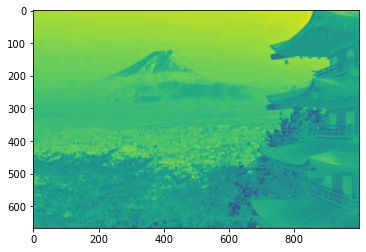

In [723]:
Cb_scaled = upscaleMatrix(Cb_joined, 2)
Cr_scaled = upscaleMatrix(Cr_joined, 2)

Cb_scaled = Cb_scaled[0:img_height, 0:img_width]
Cr_scaled = Cr_scaled[0:img_height, 0:img_width]

plt.imshow(Cr_scaled)

8. Juntamos as matrizes de Y, Cb e Cr

In [724]:
def joinMatrices(Y, Cb, Cr):
    Y_clipped = np.clip(Y, a_min=16, a_max=235)
    Cb_clipped = np.clip(Cb, a_min=16, a_max=235)
    Cr_clipped = np.clip(Cr, a_min=16, a_max=235)

    return cv2.merge((Y_clipped.astype(int), Cr_clipped.astype(int), Cb_clipped.astype(int)))

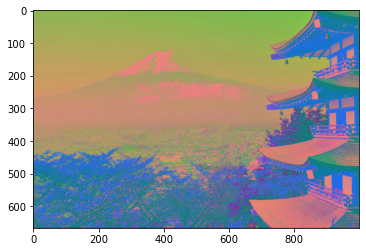

In [725]:
imgInYCbCr = joinMatrices(_Y, _Cb, _Cr)
joinedImg = joinMatrices(Y_joined, Cb_scaled, Cr_scaled)
plt.imshow(joinedImg)

9. E, finalmente, convertemos para o espaço de cores RGB e salvamos como PNG (apenas para visualização), que é um processo de compressão sem perdas.

In [726]:
def convertYCbCrToRGB(imgInYCbCr):
    RGBimg = cv2.cvtColor(imgInYCbCr, cv2.COLOR_YCrCb2RGB)
    return RGBimg

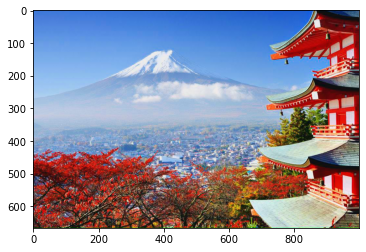

In [727]:
RGBImg = convertYCbCrToRGB(joinedImg.astype('uint8'))
cv2.imwrite('my_awesome_img.png', RGBImg)
plt.imshow(cv2.cvtColor(RGBImg, cv2.COLOR_RGB2BGR))

## Análise
Para analisar o algoritmo de compressão, vamos verificar a taxa de compressão assim como o PSNR.

## Taxa de compressão
Para calcular a taxa de compressão, dividimos o número de bits necessários para codificar os 3 canais RGB de uma imagem pelo número de bits por pixel do arquivo comprimido.
Para uma imagem colorida, precisamos de 24 bits por pixel (já que cada canal necessita de 8 bits). Abaixo é mostrado o cálculo do número de bits por pixel da imagem comprimida. 

In [728]:
def bitsPerPixel(imgSize, width, height):
    numOfPixels = width * height
    return imgSize / numOfPixels

header = encodeHeader()
final_str = header + Y_encoded + Cb_encoded + Cr_encoded
as_bytes = _to_Bytes(final_str)
bits_total = len(as_bytes) * 8

bitsPerPixel = bitsPerPixel(bits_total, img_width, img_height)
print("Taxa de compressão: %5.3f" % (24/bitsPerPixel))

Taxa de compressão: 4.296


## PSNR
O bloco PSNR calcula a relação sinal-ruído de pico entre duas imagens. Essa proporção é usada como medida de qualidade entre o original e uma imagem compactada. Quanto maior o PSNR, melhor a qualidade da imagem compactada ou reconstruída. Para imagens coloridas é comum considerar o PSNR global como sendo o do canal Y, que indica o fator de luminância do pixel. Fazemos o cálculo abaixo.

In [729]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    if rmsev == 0:
        return 0
    return 20 * np.log10(255/rmsev)

In [730]:
print ("RMSE_Y: %5.3f" % rmse(_Y, Y_joined))
print ("PSNR_Y: %5.3f" % psnr(_Y, Y_joined))

RMSE_Y: 4.983
PSNR_Y: 34.180


Calculamos também o PSNR dos canais Cb e Cr, respectivamente. Lembrando que, caso a imagem seja apenas em escala de cinza, apenas o PSNR do canal Y deve ser levado em consideração. 

In [731]:
print ("RMSE_Cb: %5.3f" % rmse(_Cb, Cb_scaled))
print ("PSNR_Cb: %5.3f" % psnr(_Cb, Cb_scaled))

print ("RMSE_Cr: %5.3f" % rmse(_Cr, Cr_scaled))
print ("PSNR_Cr: %5.3f" % psnr(_Cr, Cr_scaled))

RMSE_Cb: 9.328
PSNR_Cb: 28.735
RMSE_Cr: 6.098
PSNR_Cr: 32.427
